In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

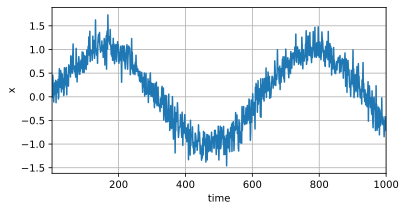

In [2]:
T = 1000 # 产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [27]:
time[0],time[-1]

(tensor(1.), tensor(1000.))

将数据映射为$y_t=x_t$和$x_t=[x_{t-\tau},\ldots,x_{t-1}]$ 的数据对

In [3]:
tau=4
features = torch.zeros(T-tau,tau)
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
# 标签是x[4:1000]的值
labels = x[tau:].reshape((-1,1))

In [17]:
batch_size, n_train = 16,600
# 前600个用于训练
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                            batch_size,is_train=True)

In [20]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# 两个全连接层带一个ReLU
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [21]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1},'
              f'loss: {d2l.evaluate_loss(net,train_iter,loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.072472
epoch 2,loss: 0.060883
epoch 3,loss: 0.055389
epoch 4,loss: 0.052278
epoch 5,loss: 0.051416


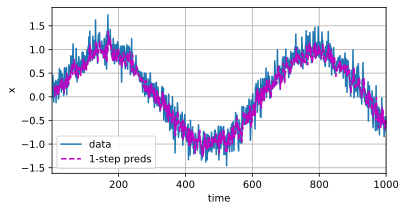

In [22]:
# 这里做的单步预测是有问题的，我们把整个features当输入传进去了
# 而对于时间序列来说，我们应该是把前tau个点传进去作为输入
# 一边生成输出，一边把输出输入进去
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x',legend=['data','1-step preds'],xlim=[1,1000],
         figsize=(6,3))

In [23]:
# 多步预测（输出输入的迭代预测）
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
# 604~1000步都是迭代预测
for i in range(n_train+tau,T):
    multistep_preds[i] = net(
        multistep_preds[i-tau:i].reshape((1,-1))
    )

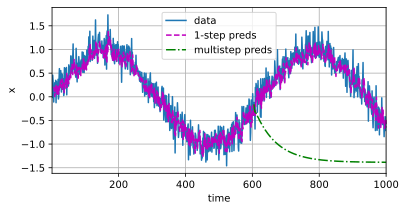

In [24]:
d2l.plot([time,time[tau:],time[n_train+tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy(),
          multistep_preds[n_train+tau:].detach().numpy()],'time',
          'x',legend=['data','1-step preds','multistep preds'],
          xlim=[1,1000],figsize=(6,3))
# 从图上可以看到，多步预测很快就出错了

In [28]:
max_steps = 64
# 下面我们看看K步预测到哪一步会出问题
# features大小为933*68
features = torch.zeros((T-tau-max_steps+1,tau+max_steps))
# 前四列填充
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]

# 从第五列开始应用net，输入是前tau列，时间步从4到67
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)

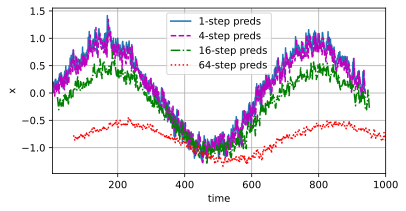

In [29]:
steps = (1,4,16,64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps],
         [features[:,(tau+i-1)].detach().numpy() for i in steps],'time','x',
         legend=[f'{i}-step preds' for i in steps],xlim=[5,1000],
         figsize=(6,3))
# 可以看到从4步开始，预测就有了偏移